In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import iris

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from IPython.display import Markdown as md
from custom_cmap import *

import matplotlib
%matplotlib inline

In [2]:
# plot characteristics 
lon_start = 80.0 # 88.0
lon_end = 140.0 # 130.0
lat_start = -10.0 # -6.0
lat_end = 40.0 # 23.0

height_level = 6000

Tp = 24    
time = int(Tp)-12

In [3]:
# read in N768 MetUM data 
gl_pe='/nobackup/earshar/borneo/case_20181021T1200Z_N768/nc/umglaa_pe{0:03d}.nc'.format(time)
gl_pc='/nobackup/earshar/borneo/case_20181021T1200Z_N768/nc/umglaa_pc{0:03d}.nc'.format(time)
gl_pb='/nobackup/earshar/borneo/case_20181021T1200Z_N768/nc/umglaa_pb{0:03d}.nc'.format(time)
    
input_data_pe = xr.open_dataset(gl_pe) # vertical velocity 
input_data_pc = xr.open_dataset(gl_pc, drop_variables=['unspecified_5','unspecified_6',   # heating rate 
                                                       'unspecified_9','unspecified_10'])
input_data_pb = xr.open_dataset(gl_pb)

In [4]:
# create variable for v_tot (v-wind)
vwind = input_data_pe.v.squeeze('t').sel(latitude_1=slice(lat_start, 
                                        lat_end)).sel(longitude=slice(lon_start, lon_end))
uwind = input_data_pe.u.squeeze('t').sel(latitude=slice(lat_start, 
                                        lat_end)).sel(longitude_1=slice(lon_start, lon_end))
theta = input_data_pb.theta_1.squeeze('t').sel(latitude=slice(lat_start,
                                        lat_end)).sel(longitude=slice(lon_start, lon_end))

In [5]:
# read in SGT tool data, and create variable for v_geo (geostrophic component of v-wind)
sgt_path = "/nobackup/earshar/borneo/SGTool/N768/oct/control/filter_4_8/conv_g7x_v5"
sgt_file_v = f"{sgt_path}/OUT_v_20181021T1200Z_T0{Tp}.nc"
iris_array_v = iris.load(sgt_file_v)[0]
vwind_sgt = xr.DataArray.from_iris(iris_array_v).sel(latitude=slice(lat_start,lat_end)).sel(longitude=slice(lon_start,lon_end))

sgt_file_vg = f"{sgt_path}/OUT_vg_20181021T1200Z_T0{Tp}.nc"
iris_array_vg = iris.load(sgt_file_vg)[0]
vg_wind = xr.DataArray.from_iris(iris_array_vg).sel(latitude=slice(lat_start,lat_end)).sel(longitude=slice(lon_start,lon_end))

sgt_file_vg_um = f"{sgt_path}/OUT_vg_um_20181021T1200Z_T0{Tp}.nc"
iris_array_vg_um = iris.load(sgt_file_vg_um)[0]
vg_um_wind = xr.DataArray.from_iris(iris_array_vg_um).sel(latitude=slice(lat_start,lat_end)).sel(longitude=slice(lon_start,lon_end))

In [6]:
# select single level to plot
vwind_6km = vwind.sel(hybrid_ht_1=height_level,method='nearest')
vg_wind_6km = vg_wind.sel(model_level_number=29)
vg_um_wind_6km = vg_um_wind.sel(model_level_number=29)

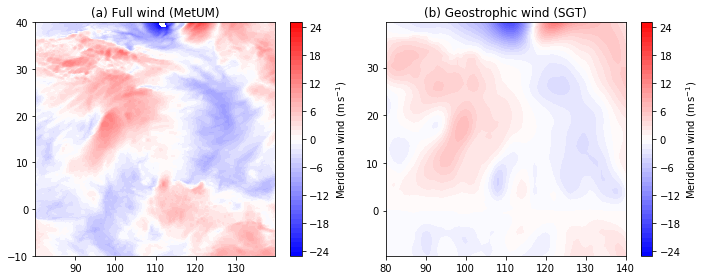

In [7]:
# panel plot of total vs geostrophic wind (v-component)
dl = 1.0; vmin = -25.0; vmax = -vmin + dl
Cmap,norm,Levels = normalise_cmap(vmin,vmax,0,dl,'bwr')
variable = vg_wind_6km

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
left_panel = ax[0].contourf(vwind_6km.longitude, vwind_6km.latitude_1, vwind_6km, levels=Levels, cmap=Cmap)
plt.colorbar(left_panel, ax=ax[0], label=r'Meridional wind $\mathrm{(m\,s^{-1})}$')
ax[0].set_title(r'(a) Full wind (MetUM)')

right_panel = ax[1].contourf(variable.longitude, variable.latitude, variable, levels=Levels, cmap=Cmap)
plt.colorbar(right_panel, ax=ax[1], label=r'Meridional wind $\mathrm{(m\,s^{-1})}$')
ax[1].set_title(r'(b) Geostrophic wind (SGT)')

fig.tight_layout()
plt.show()
fig.savefig('total_vs_geostrophic_wind_t24_6km.png')

In [8]:
# create new vertical height coordinate ('height_levels') and interpolate onto it
ht_coords = uwind['hybrid_ht_1'].data.astype('int32')
vwind = vwind.interp(hybrid_ht_1=ht_coords, method='linear')
vwind = vwind.assign_coords(height_levels=("hybrid_ht_1", ht_coords))
vwind = vwind.swap_dims({"hybrid_ht_1":"height_levels"})

# repeat for theta
theta = theta.interp(hybrid_ht=ht_coords, method='linear')
theta = theta.assign_coords(height_levels=("hybrid_ht", ht_coords))
theta = theta.swap_dims({"hybrid_ht":"height_levels"})

In [9]:
# repeat for the SGT tool data (L671 in plot_4p4.py)
vwind_sgt = vwind_sgt.assign_coords(height_levels=("model_level_number", 
                                    ht_coords)).swap_dims({"model_level_number":"height_levels"})

vg_wind = vg_wind.assign_coords(height_levels=("model_level_number", 
                                    ht_coords)).swap_dims({"model_level_number":"height_levels"})

vg_um_wind = vg_um_wind.assign_coords(height_levels=("model_level_number", 
                                    ht_coords)).swap_dims({"model_level_number":"height_levels"})

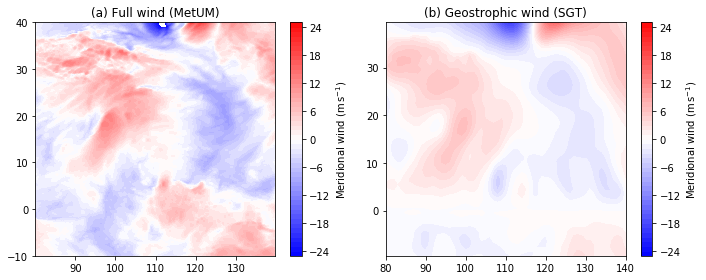

In [10]:
# panel plot of total vs geostrophic wind (v-component)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
vwind_6km_new = vwind.sel(height_levels=height_level,method='nearest')
left_panel = ax[0].contourf(vwind_6km_new.longitude, vwind_6km_new.latitude_1, vwind_6km_new, levels=Levels, cmap=Cmap)
plt.colorbar(left_panel, ax=ax[0], label=r'Meridional wind $\mathrm{(m\,s^{-1})}$')
ax[0].set_title(r'(a) Full wind (MetUM)')

vg_wind_6km_new = vg_wind.sel(height_levels=height_level,method='nearest')
right_panel = ax[1].contourf(vg_wind_6km_new.longitude, vg_wind_6km_new.latitude, vg_wind_6km_new, levels=Levels, cmap=Cmap)
plt.colorbar(right_panel, ax=ax[1], label=r'Meridional wind $\mathrm{(m\,s^{-1})}$')
ax[1].set_title(r'(b) Geostrophic wind (SGT)')

fig.tight_layout()
plt.show()
fig.savefig('total_vs_geostrophic_wind_t24_6km_new.png')

In [11]:
# linearly interpolate the SGT tool data onto the N768 grid (L422; plot_4p4.py)
vwind_sgt = vwind_sgt.interp(latitude=theta.latitude, longitude=theta.longitude)
vg_wind = vg_wind.interp(latitude=theta.latitude, longitude=theta.longitude)
vg_um_wind = vg_um_wind.interp(latitude=theta.latitude, longitude=theta.longitude)
vwind = vwind.interp(latitude_1=theta.latitude, longitude=theta.longitude)

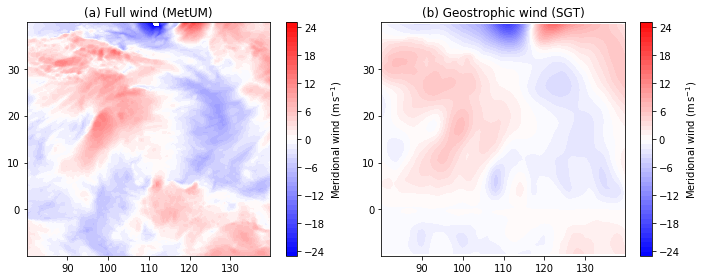

In [12]:
# panel plot of total vs geostrophic wind (v-component)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
vwind_6km_new = vwind.sel(height_levels=height_level,method='nearest')
left_panel = ax[0].contourf(vwind_6km_new.longitude, vwind_6km_new.latitude_1, vwind_6km_new, levels=Levels, cmap=Cmap)
plt.colorbar(left_panel, ax=ax[0], label=r'Meridional wind $\mathrm{(m\,s^{-1})}$')
ax[0].set_title(r'(a) Full wind (MetUM)')

vg_wind_6km_new = vg_wind.sel(height_levels=height_level,method='nearest')
right_panel = ax[1].contourf(vg_wind_6km_new.longitude, vg_wind_6km_new.latitude, vg_wind_6km_new, levels=Levels, cmap=Cmap)
plt.colorbar(right_panel, ax=ax[1], label=r'Meridional wind $\mathrm{(m\,s^{-1})}$')
ax[1].set_title(r'(b) Geostrophic wind (SGT)')

fig.tight_layout()
plt.show()
fig.savefig('total_vs_geostrophic_wind_t24_6km_interp.png')

In [13]:
# set up vertical cross-section 
lat_cs = 6.0 
lon_start = lon_start - 0.5
lon_end = lon_end + 0.5

In [14]:
# set up colour bar 
dl = 1.0; vmin = -25.0; vmax = -vmin + dl
Cmap,norm,Levels=normalise_cmap(vmin,vmax,0,dl,'bwr')
cb_label=r'Meridional wind $\mathregular{(m\,s^{-1})}$'

In [16]:
# select the cross-section location 

# N768 total wind
arr_vt = vwind.sel(latitude=lat_cs, method="nearest")
arr_vt = arr_vt.sel(longitude=slice(lon_start,lon_end),
                    height_levels=slice(50, 15000) )

# SGT total wind
arr_vt_sgt = vwind_sgt.sel(latitude=lat_cs, method="nearest")
arr_vt_sgt = arr_vt_sgt.sel(longitude=slice(lon_start,lon_end),
                    height_levels=slice(50, 15000) )

# SGT geostrophic wind (smoothed/filtered)
arr_vg = vg_wind.sel(latitude=lat_cs, method="nearest")
arr_vg = arr_vg.sel(longitude=slice(lon_start,lon_end),
                    height_levels=slice(50, 15000) )

# SGT geostrophic wind (unfiltered)
arr_vg2 = vg_um_wind.sel(latitude=lat_cs, method="nearest")
arr_vg2 = arr_vg2.sel(longitude=slice(lon_start,lon_end),
                    height_levels=slice(50, 15000) )

# N768 theta 
arr_th = theta.sel(latitude=lat_cs, method="nearest")
arr_th = arr_th.sel(longitude=slice(lon_start,lon_end),
                    height_levels=slice(50, 15000) )

In [17]:
# interpolate to new height coordinates before plotting 
ht_coords = np.arange(0, 13500, 250)
arr_vt = arr_vt.interp(height_levels=ht_coords,method="linear")
arr_vt_sgt = arr_vt_sgt.interp(height_levels=ht_coords,method="linear")
arr_vg = arr_vg.interp(height_levels=ht_coords,method="linear")
arr_vg2 = arr_vg2.interp(height_levels=ht_coords,method="linear")
arr_th = arr_th.interp(height_levels=ht_coords,method="linear")

In [18]:
# set up longitude coordinate before plotting
lon_dim = np.arange(np.rint(arr_th.longitude[0].data),
                    np.rint(arr_th.longitude[-1].data)+0.25, 0.25)
arr_vt = arr_vt.interp(longitude=lon_dim, method="linear")
arr_vt_sgt = arr_vt_sgt.interp(longitude=lon_dim, method="linear")
arr_vg = arr_vg.interp(longitude=lon_dim, method="linear")
arr_vg2 = arr_vg2.interp(longitude=lon_dim, method="linear")
arr_th = arr_th.interp(longitude=lon_dim, method="linear")

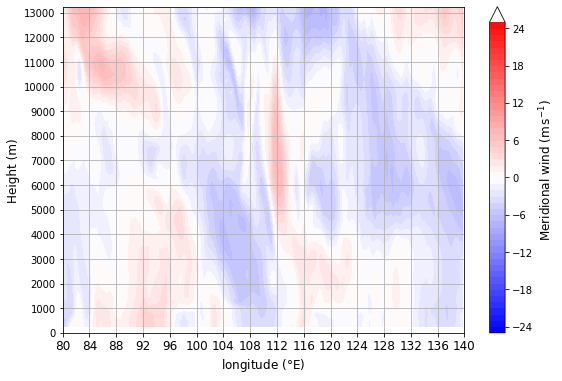

In [19]:
# tickmarks and labels (L1553 in plot_4p4.py)
fig = plt.figure(figsize=[9,6])
ax = plt.axes()
ax.grid(True)

xint = 1; yint = 4
ts = np.rint(arr_vt.longitude[0].data)
tf = np.rint(arr_vt.longitude[-1].data)
dim_size = len(arr_vt.longitude)
ax.set_xlabel(r'longitude ($\degree$E)', fontsize='large')

# set x-axis tickmarks every 2º
ax.set_xlim(0, dim_size-1)
ax.set_xticks(np.arange(0, dim_size+1, 16) )
ax.set_xticklabels(np.arange(int(ts), int(tf+1), yint) , fontsize='large')

# y-axis tickmarks and labels 
mlev_size = len(arr_vt.height_levels)
ax.set_yticks(np.arange(0, mlev_size, 4) )
ax.set_yticklabels(arr_vt.height_levels[::4].data)
ax.set_ylabel('Height (m)', fontsize='large')

# plot cross-section (total wind)
var_contour = plt.contourf(arr_vt, levels=Levels, extend='max', cmap=Cmap)
var_cbar = fig.colorbar(var_contour)
var_cbar.set_label(cb_label, fontsize='large')
plt.savefig('vtot_n768_cross_section_t24.png',dpi=200)

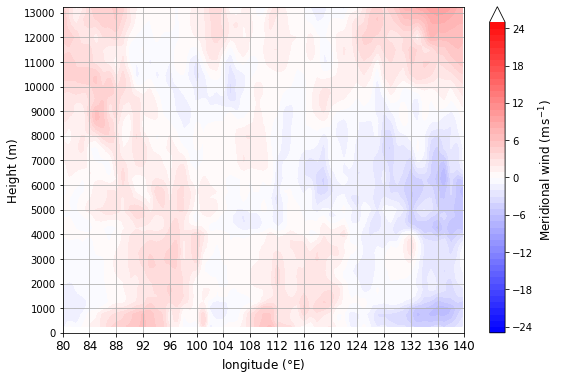

In [20]:
# tickmarks and labels (L1553 in plot_4p4.py)
fig = plt.figure(figsize=[9,6])
ax = plt.axes()
ax.grid(True)

xint = 1; yint = 4
ts = np.rint(arr_vt.longitude[0].data)
tf = np.rint(arr_vt.longitude[-1].data)
dim_size = len(arr_vt.longitude)
ax.set_xlabel(r'longitude ($\degree$E)', fontsize='large')

# set x-axis tickmarks every 2º
ax.set_xlim(0, dim_size-1)
ax.set_xticks(np.arange(0, dim_size+1, 16) )
ax.set_xticklabels(np.arange(int(ts), int(tf+1), yint) , fontsize='large')

# y-axis tickmarks and labels 
mlev_size = len(arr_vt.height_levels)
ax.set_yticks(np.arange(0, mlev_size, 4) )
ax.set_yticklabels(arr_vt.height_levels[::4].data)
ax.set_ylabel('Height (m)', fontsize='large')

# plot cross-section (total wind)
var_contour = plt.contourf(arr_vt_sgt, levels=Levels, extend='max', cmap=Cmap)
var_cbar = fig.colorbar(var_contour)
var_cbar.set_label(cb_label, fontsize='large')
plt.savefig('vtot_sgt_cross_section_t24.png',dpi=200)

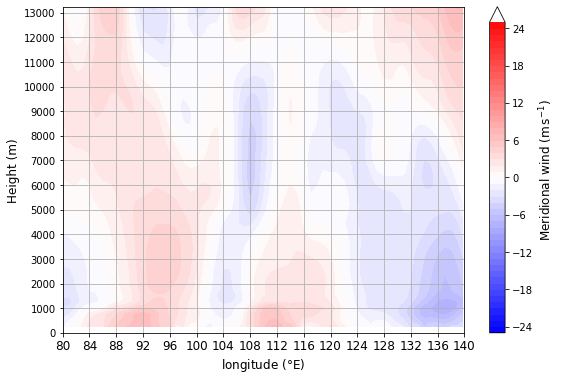

In [21]:
# tickmarks and labels (L1553 in plot_4p4.py)
fig = plt.figure(figsize=[9,6])
ax = plt.axes()
ax.grid(True)

xint = 1; yint = 4
ts = np.rint(arr_vt.longitude[0].data)
tf = np.rint(arr_vt.longitude[-1].data)
dim_size = len(arr_vt.longitude)
ax.set_xlabel(r'longitude ($\degree$E)', fontsize='large')

# set x-axis tickmarks every 2º
ax.set_xlim(0, dim_size-1)
ax.set_xticks(np.arange(0, dim_size+1, 16) )
ax.set_xticklabels(np.arange(int(ts), int(tf+1), yint) , fontsize='large')

# y-axis tickmarks and labels 
mlev_size = len(arr_vt.height_levels)
ax.set_yticks(np.arange(0, mlev_size, 4) )
ax.set_yticklabels(arr_vt.height_levels[::4].data)
ax.set_ylabel('Height (m)', fontsize='large')

# plot cross-section (geostrophic wind)
var_contour = plt.contourf(arr_vg, levels=Levels, extend='max', cmap=Cmap)
var_cbar = fig.colorbar(var_contour)
var_cbar.set_label(cb_label, fontsize='large')
plt.savefig('smooth_vgeo_cross_section_t24.png',dpi=200)

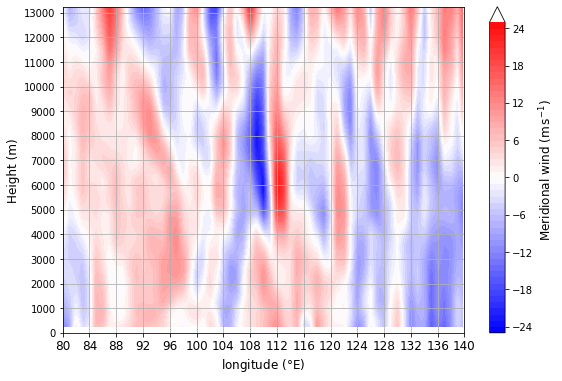

In [22]:
# tickmarks and labels (L1553 in plot_4p4.py)
fig = plt.figure(figsize=[9,6])
ax = plt.axes()
ax.grid(True)

xint = 1; yint = 4
ts = np.rint(arr_vt.longitude[0].data)
tf = np.rint(arr_vt.longitude[-1].data)
dim_size = len(arr_vt.longitude)
ax.set_xlabel(r'longitude ($\degree$E)', fontsize='large')

# set x-axis tickmarks every 2º
ax.set_xlim(0, dim_size-1)
ax.set_xticks(np.arange(0, dim_size+1, 16) )
ax.set_xticklabels(np.arange(int(ts), int(tf+1), yint) , fontsize='large')

# y-axis tickmarks and labels 
mlev_size = len(arr_vt.height_levels)
ax.set_yticks(np.arange(0, mlev_size, 4) )
ax.set_yticklabels(arr_vt.height_levels[::4].data)
ax.set_ylabel('Height (m)', fontsize='large')

# plot cross-section (geostrophic wind)
var_contour = plt.contourf(arr_vg2, levels=Levels, extend='max', cmap=Cmap)
var_cbar = fig.colorbar(var_contour)
var_cbar.set_label(cb_label, fontsize='large')
plt.savefig('non_smooth_vgeo_cross_section_t24.png',dpi=200)